In [150]:
import pandas as pd
import numpy as np
from fasteda import fast_eda
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer


In [144]:
df = pd.read_csv("/Users/mak/Desktop/Code_With_Me/Defaulting/Loan_Default.csv")

In [145]:
df.Status.unique()

array([1., 0.])

In [146]:
df.drop(['ID','year','Unnamed: 0'], axis=1, inplace=True)

In [147]:
df_na = df.dropna(subset=['Status'])

In [148]:
df_na.shape

(148670, 32)

In [149]:
cat_vars = []
num_vars = []
for i in df_na.columns:
    if(df_na[i].dtype == "object"):
        cat_vars.append(i)
    else:
        num_vars.append(i)
print("Categorical Variables:\n",cat_vars,"\n")
print("Numerical Variables:\n",num_vars,"\n")

Categorical Variables:
 ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region', 'Security_Type'] 

Numerical Variables:
 ['loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'property_value', 'income', 'Credit_Score', 'LTV', 'Status', 'dtir1'] 



In [152]:
df_num = df_na[num_vars]
knn = KNNImputer(n_neighbors = 3)
knn.fit(df_num)
X = knn.fit_transform(df_num)

KeyboardInterrupt: 

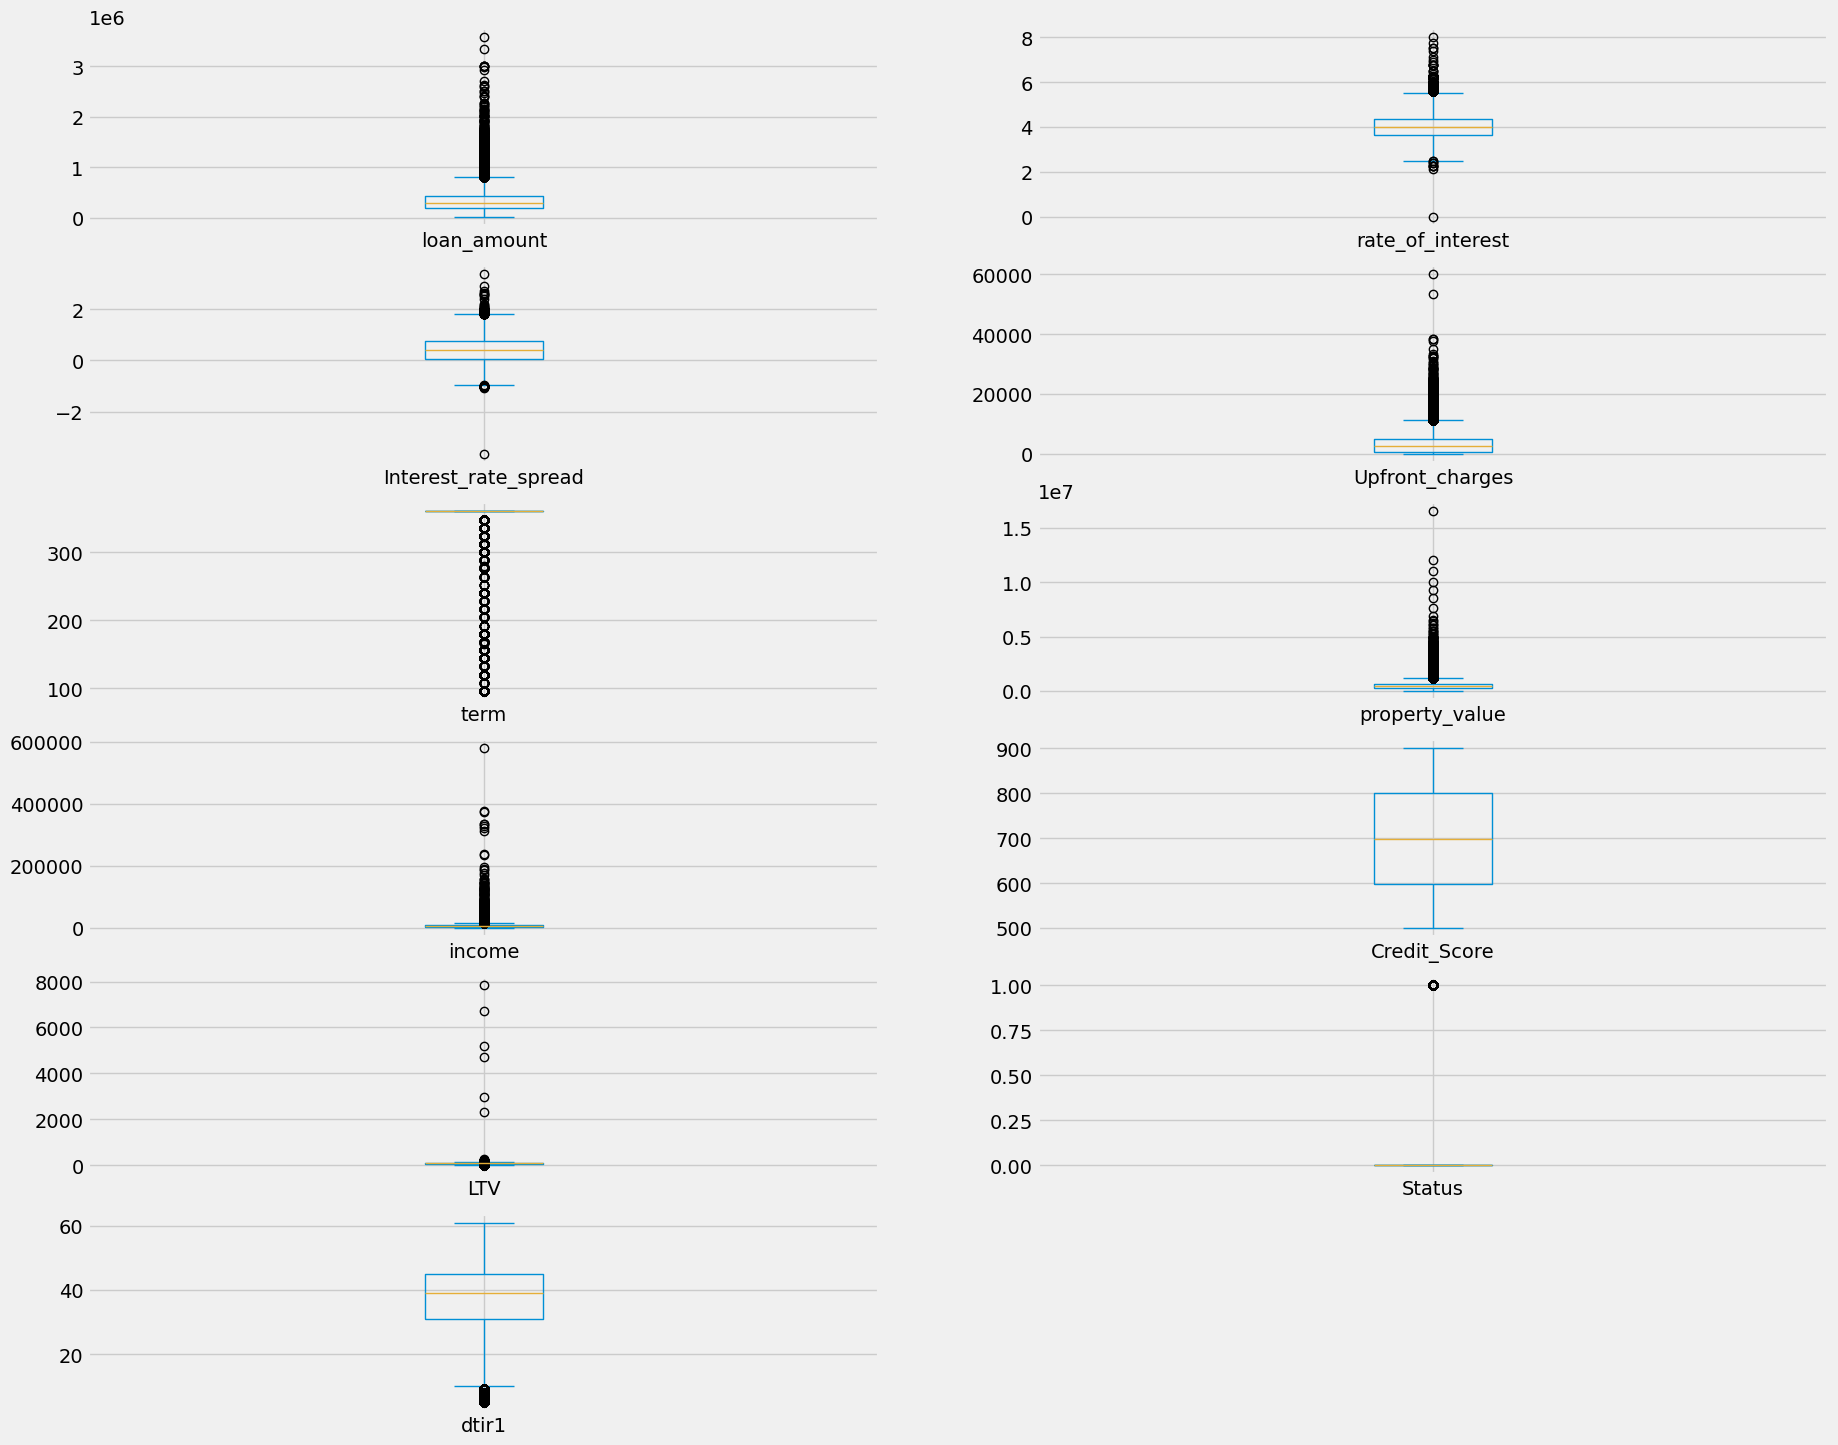

In [80]:
df_na.plot(kind="box",subplots=True,layout=(7,2),figsize=(20,20));


Plots after removing outliers:



loan_amount                  Axes(0.08,0.78122;0.395455x0.0987805)
rate_of_interest         Axes(0.554545,0.78122;0.395455x0.0987805)
Interest_rate_spread        Axes(0.08,0.662683;0.395455x0.0987805)
Upfront_charges         Axes(0.554545,0.662683;0.395455x0.0987805)
term                        Axes(0.08,0.544146;0.395455x0.0987805)
property_value          Axes(0.554545,0.544146;0.395455x0.0987805)
income                       Axes(0.08,0.42561;0.395455x0.0987805)
Credit_Score             Axes(0.554545,0.42561;0.395455x0.0987805)
LTV                         Axes(0.08,0.307073;0.395455x0.0987805)
Status                  Axes(0.554545,0.307073;0.395455x0.0987805)
dtir1                       Axes(0.08,0.188537;0.395455x0.0987805)
dtype: object

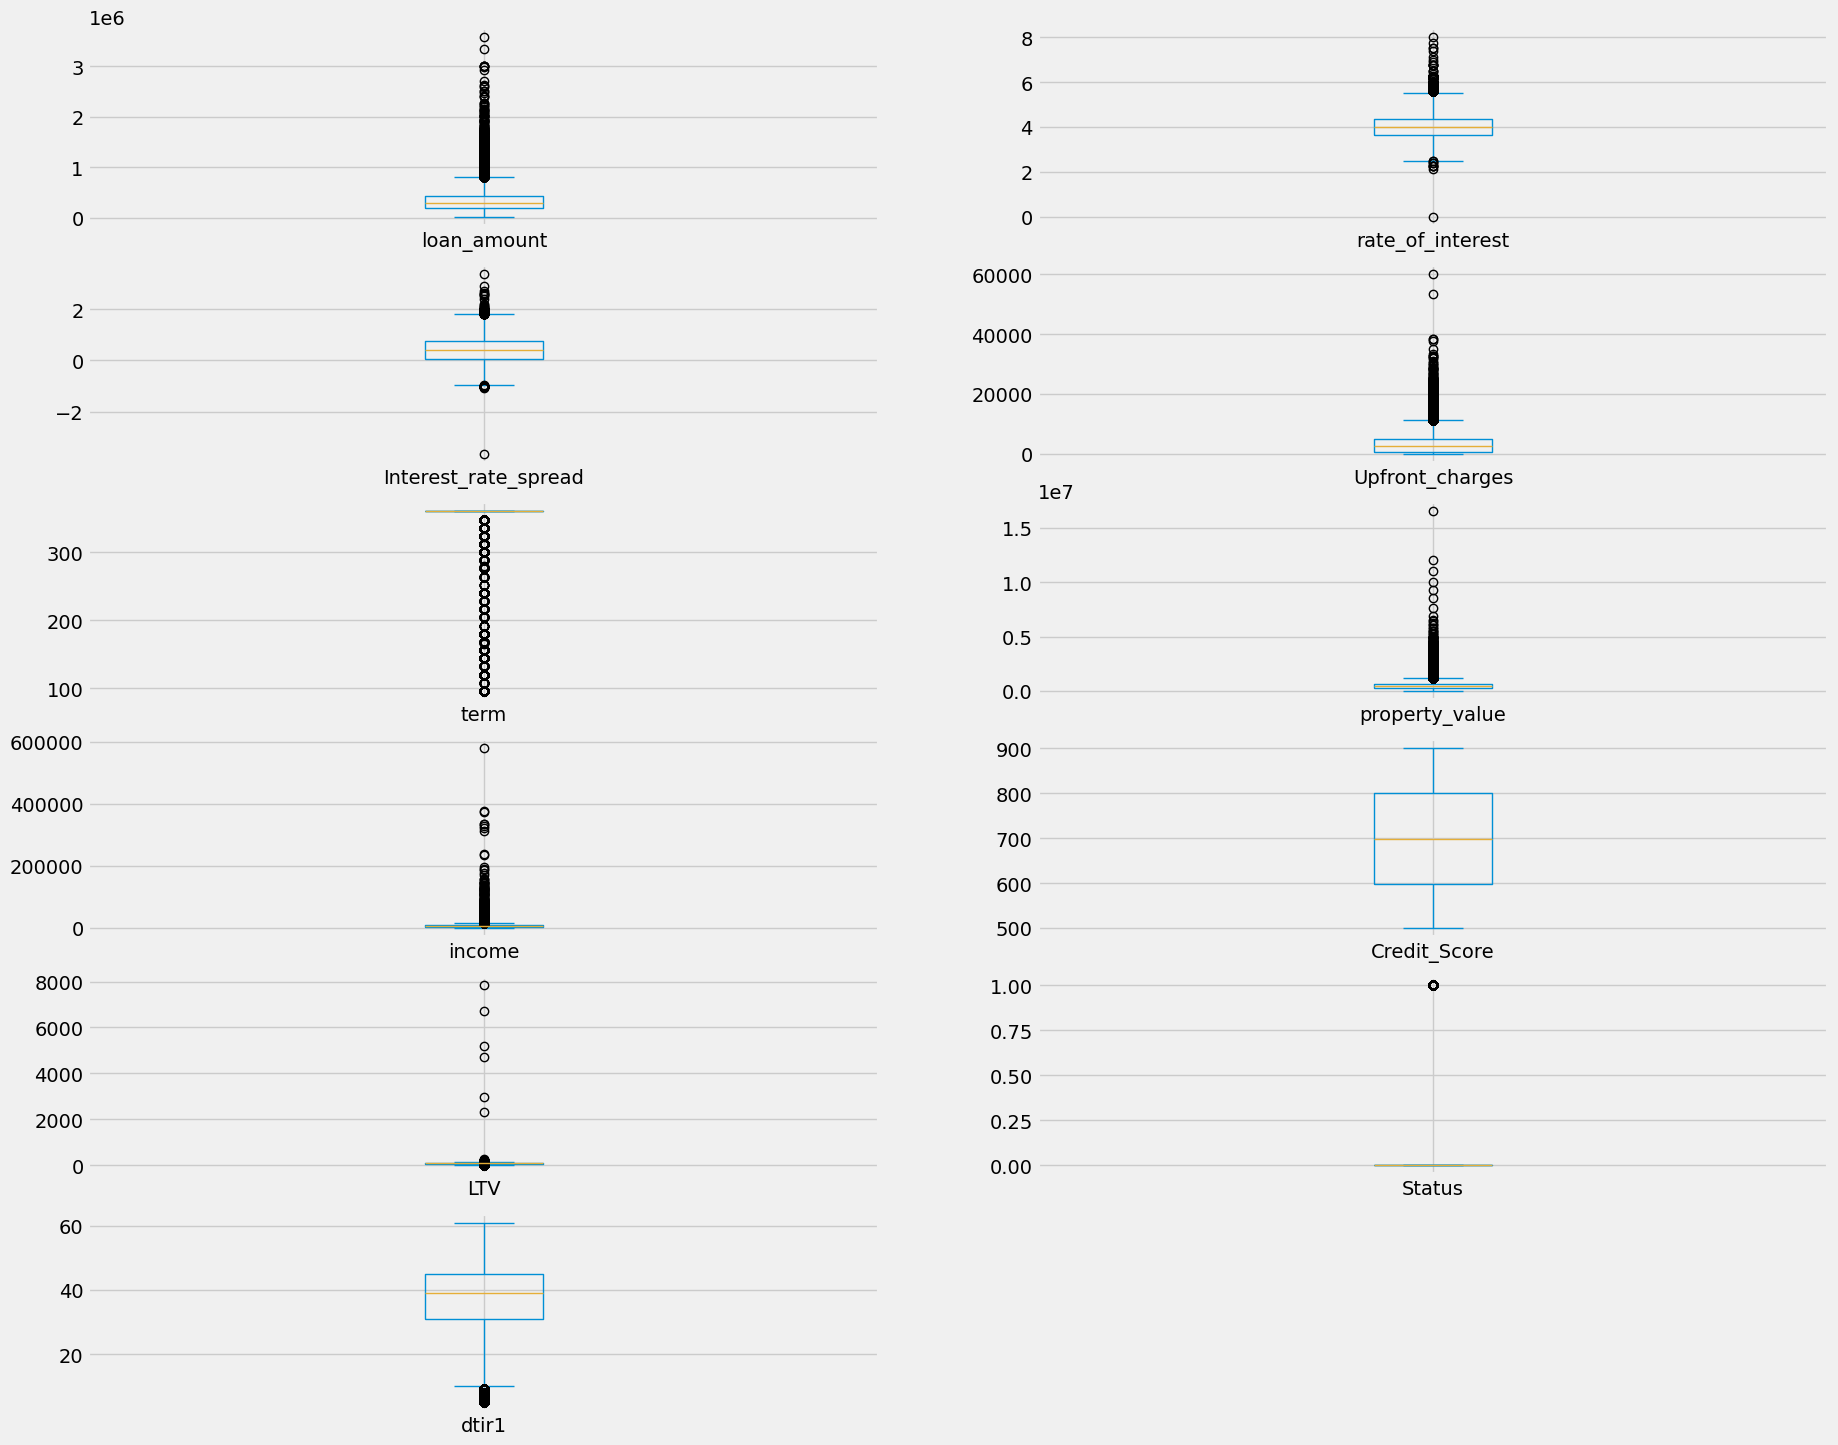

In [121]:
def drop_outliers(df, field_name):
    iqr = 1.5 * (np.percentile(df[field_name], 75) - np.percentile(df[field_name], 25))
    upper_bound = iqr + np.percentile(df[field_name], 75)
    lower_bound = np.percentile(df[field_name], 25) - iqr

    if ((df[field_name] > upper_bound) | (df[field_name] < lower_bound)).empty:
        print("No outliers to drop.")
        return df.drop(df[(df[field_name] > upper_bound) | (df[field_name] < lower_bound)].index, inplace=True)

drop_outliers(df_na, "loan_amount")
drop_outliers(df_na, "rate_of_interest")
drop_outliers(df_na, "Interest_rate_spread")
drop_outliers(df_na, "Upfront_charges")
drop_outliers(df_na, "property_value")
drop_outliers(df_na, "income")
drop_outliers(df_na, "LTV")

drop_outliers(df_na, "term")
drop_outliers(df_na, "dtir1")

print("Plots after removing outliers:\n")
df_na.plot(kind="box", subplots=True, layout=(7,2), figsize=(20,20))

In [102]:
import matplotlib.pyplot as plt

def drop_outliers_with_visualization(df, field_name, iqr_multiplier=1.5):
    
    """
    Identifies and optionally removes outliers in a DataFrame column using the Interquartile Range (IQR) method.
    Provides informative visualizations of the distribution before and after outlier removal.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        field_name (str): The name of the column containing the numeric data.
        iqr_multiplier (float, optional): A multiplier for the IQR to determine outlier thresholds (default: 1.5).
            Higher values remove more outliers, while lower values remove fewer.

    Returns:
        pandas.DataFrame: The original DataFrame (potentially modified by outlier removal).
    """

    q1 = np.percentile(df[field_name], 25)
    q3 = np.percentile(df[field_name], 75)
    iqr = iqr_multiplier * (q3 - q1)  # Adjust outlier thresholds with iqr_multiplier

    upper_bound = q3 + iqr
    lower_bound = q1 - iqr

    outliers = (df[field_name] > upper_bound) | (df[field_name] < lower_bound)

    if not outliers.any():
        print(f"No outliers detected in '{field_name}'.")
        return df

    # Create visualizations before and after outlier removal
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))  # Adjust figure size as needed

    axes[0].boxplot(df[field_name])
    axes[0].set_title(f"Distribution of '{field_name}' Before Outlier Removal")
    axes[0].set_xlabel(field_name)
    axes[0].set_ylabel("Value")

    df_filtered = df.loc[~outliers]  # Filter out outliers for visualization
    axes[1].boxplot(df_filtered[field_name])
    axes[1].set_title(f"Distribution of '{field_name}' After Outlier Removal")
    axes[1].set_xlabel(field_name)
    axes[1].set_ylabel("Value")

    plt.tight_layout()
    plt.show()

    # Optionally remove outliers
    confirmation = 'y'
    if confirmation.lower() == 'y':
        df.drop(df[outliers].index, inplace=True)
        print(f"{len(outliers.sum())} outliers removed from '{field_name}'.")
    else:
        print(f"Outlier removal skipped for '{field_name}'.")

    return df

# Example usage

fields_to_check = ["loan_amount", "rate_of_interest", "Interest_rate_spread", "Upfront_charges",
                   "property_value", "income", "LTV", "term", "dtir1"]


df_na = drop_outliers_with_visualization(df_na, 'dtir1')  # Operate on a copy to avoid modifying original data

# After outlier analysis and potential removal, you can use df_full for further processing

No outliers detected in 'dtir1'.


loan_amount                  Axes(0.08,0.78122;0.395455x0.0987805)
rate_of_interest         Axes(0.554545,0.78122;0.395455x0.0987805)
Interest_rate_spread        Axes(0.08,0.662683;0.395455x0.0987805)
Upfront_charges         Axes(0.554545,0.662683;0.395455x0.0987805)
term                        Axes(0.08,0.544146;0.395455x0.0987805)
property_value          Axes(0.554545,0.544146;0.395455x0.0987805)
income                       Axes(0.08,0.42561;0.395455x0.0987805)
Credit_Score             Axes(0.554545,0.42561;0.395455x0.0987805)
LTV                         Axes(0.08,0.307073;0.395455x0.0987805)
Status                  Axes(0.554545,0.307073;0.395455x0.0987805)
dtir1                       Axes(0.08,0.188537;0.395455x0.0987805)
dtype: object

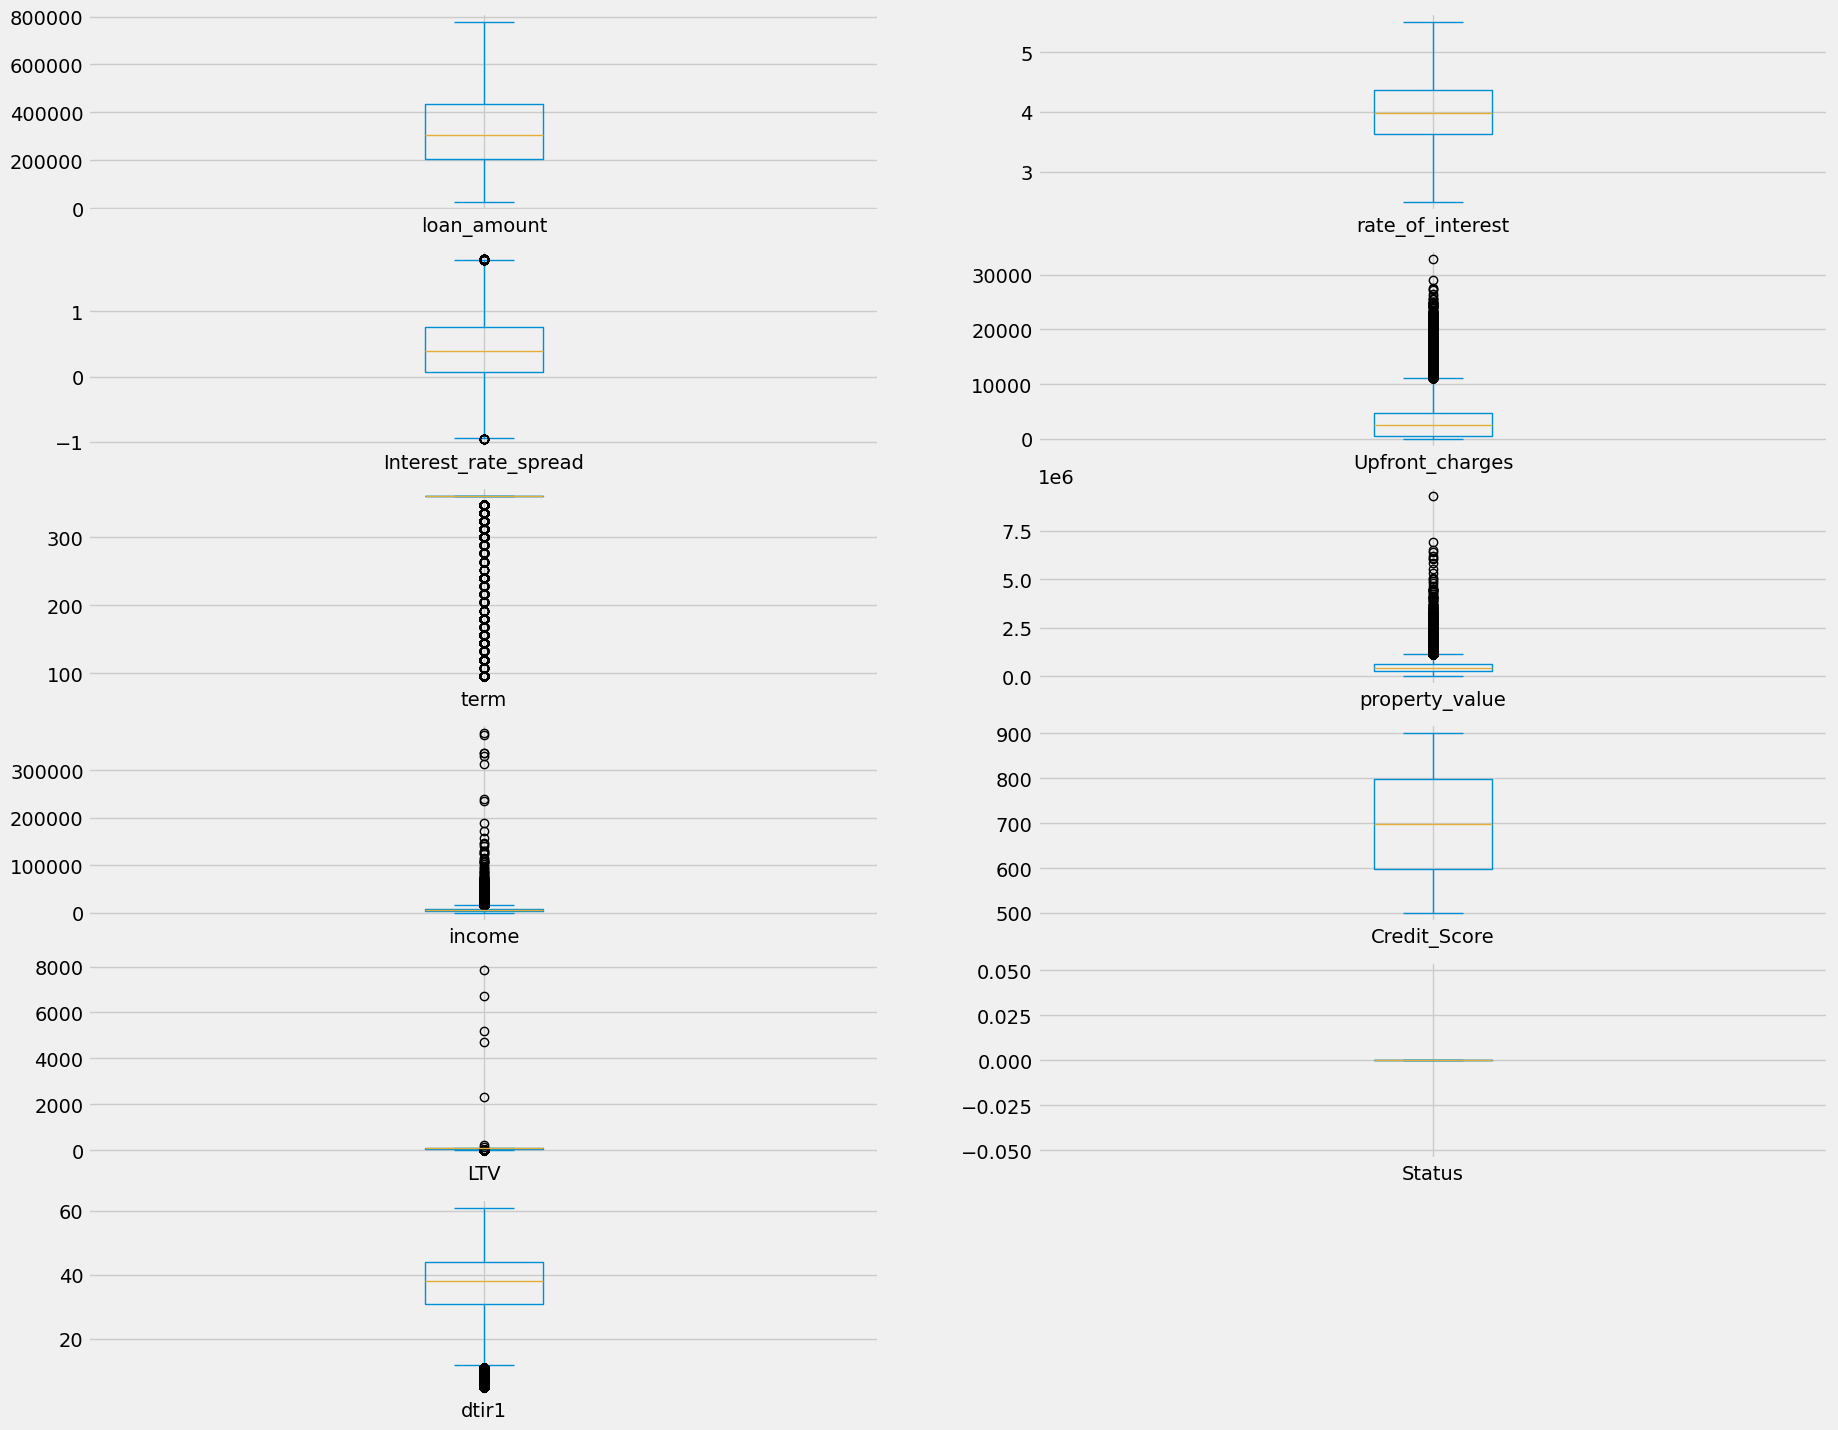

In [103]:
df_na.plot(kind="box", subplots=True, layout=(7,2), figsize=(20,20))

In [122]:
df_no_default = df_na.loc[(df_na['Status']==0)]
df_default = df_na.loc[(df_na['Status']==1)]

In [123]:
df_na.Status.unique()

array([1., 0.])

In [125]:
from sklearn.utils import resample

df_no_default_downsampled = resample(df_no_default, replace=False, n_samples=36000, random_state=42 )
df_default_downsampled = resample(df_default, replace=False, n_samples=36000, random_state=42 )

In [126]:
df_downsample = pd.concat([df_no_default_downsampled, df_default_downsampled ])
len(df_downsample)

72000

In [127]:
X = df_downsample.drop('Status', axis=1).copy()


In [128]:
cat_vars = []
num_vars = []
for i in df_na.columns:
    if(df_na[i].dtype == "object"):
        cat_vars.append(i)
    else:
        num_vars.append(i)
print("Categorical Variables:\n",cat_vars,"\n")
from sklearn.preprocessing import OneHotEncoder, scale, LabelEncoder
print("Numerical Variables:\n",num_vars,"\n")

Categorical Variables:
 ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region', 'Security_Type'] 

Numerical Variables:
 ['loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'property_value', 'income', 'Credit_Score', 'LTV', 'Status', 'dtir1'] 



In [129]:
from sklearn.preprocessing import OneHotEncoder, scale, LabelEncoder


ohe = OneHotEncoder(sparse_output=False, dtype="int")
ohe.fit(X[cat_vars])
X_ohe_train = ohe.transform(X[cat_vars])

X_ohe_train

array([[0, 0, 1, ..., 1, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 0, 0, 1]])

In [130]:

transformed_ohe = pd.DataFrame(
    data=X_ohe_train,
    columns=ohe.get_feature_names_out(cat_vars),
    index=X.index,
)
transformed_ohe.head()

,loan_limit_cf,loan_limit_ncf,loan_limit_nan,Gender_Female,Gender_Joint,Gender_Male,Gender_Sex Not Available,approv_in_adv_nopre,approv_in_adv_pre,approv_in_adv_nan,loan_type_type1,loan_type_type2,loan_type_type3,loan_purpose_p1,loan_purpose_p2,loan_purpose_p3,loan_purpose_p4,loan_purpose_nan,Credit_Worthiness_l1,Credit_Worthiness_l2,open_credit_nopc,open_credit_opc,business_or_commercial_b/c,business_or_commercial_nob/c,Neg_ammortization_neg_amm,Neg_ammortization_not_neg,Neg_ammortization_nan,interest_only_int_only,interest_only_not_int,lump_sum_payment_lpsm,lump_sum_payment_not_lpsm,construction_type_mh,construction_type_sb,occupancy_type_ir,occupancy_type_pr,occupancy_type_sr,Secured_by_home,Secured_by_land,total_units_1U,total_units_2U,total_units_3U,total_units_4U,credit_type_CIB,credit_type_CRIF,credit_type_EQUI,credit_type_EXP,co-applicant_credit_type_CIB,co-applicant_credit_type_EXP,age_25-34,age_35-44,age_45-54,age_55-64,age_65-74,age_<25,age_>74,age_nan,submission_of_application_not_inst,submission_of_application_to_inst,submission_of_application_nan,Region_North,Region_North-East,Region_central,Region_south,Security_Type_Indriect,Security_Type_direct
130220,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1
52597,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1
84169,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
144846,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1
67253,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1


In [134]:
X_encoded = pd.concat([X[['loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'property_value', 'income', 'Credit_Score', 'LTV', 'dtir1'] ], transformed_ohe], axis=1)
X_encoded.head()

,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,dtir1,loan_limit_cf,loan_limit_ncf,loan_limit_nan,Gender_Female,Gender_Joint,Gender_Male,Gender_Sex Not Available,approv_in_adv_nopre,approv_in_adv_pre,approv_in_adv_nan,loan_type_type1,loan_type_type2,loan_type_type3,loan_purpose_p1,loan_purpose_p2,loan_purpose_p3,loan_purpose_p4,loan_purpose_nan,Credit_Worthiness_l1,Credit_Worthiness_l2,open_credit_nopc,open_credit_opc,business_or_commercial_b/c,business_or_commercial_nob/c,Neg_ammortization_neg_amm,Neg_ammortization_not_neg,Neg_ammortization_nan,interest_only_int_only,interest_only_not_int,lump_sum_payment_lpsm,lump_sum_payment_not_lpsm,construction_type_mh,construction_type_sb,occupancy_type_ir,occupancy_type_pr,occupancy_type_sr,Secured_by_home,Secured_by_land,total_units_1U,total_units_2U,total_units_3U,total_units_4U,credit_type_CIB,credit_type_CRIF,credit_type_EQUI,credit_type_EXP,co-applicant_credit_type_CIB,co-applicant_credit_type_EXP,age_25-34,age_35-44,age_45-54,age_55-64,age_65-74,age_<25,age_>74,age_nan,submission_of_application_not_inst,submission_of_application_to_inst,submission_of_application_nan,Region_North,Region_North-East,Region_central,Region_south,Security_Type_Indriect,Security_Type_direct
130220,176500.0,4.375,1.0035,1968.75,180.0,308000.0,4500.0,520.0,57.305195,26.0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1
52597,476500.0,3.990,-0.2357,7747.80,360.0,608000.0,7560.0,771.0,78.371711,31.0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1
84169,726500.0,3.875,0.2231,7571.88,360.0,858000.0,10620.0,750.0,84.673660,44.0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
144846,726500.0,4.000,0.2330,950.00,360.0,1108000.0,10560.0,613.0,65.568592,44.0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1
67253,96500.0,5.500,1.4713,2960.00,360.0,198000.0,5700.0,553.0,48.737374,38.0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1


In [135]:
y = df_downsample['Status'].copy()
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

#scale the data
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

In [136]:
X.columns

Index(['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose',
       'Credit_Worthiness', 'open_credit', 'business_or_commercial',
       'loan_amount', 'rate_of_interest', 'Interest_rate_spread',
       'Upfront_charges', 'term', 'Neg_ammortization', 'interest_only',
       'lump_sum_payment', 'property_value', 'construction_type',
       'occupancy_type', 'Secured_by', 'total_units', 'income', 'credit_type',
       'Credit_Score', 'co-applicant_credit_type', 'age',
       'submission_of_application', 'LTV', 'Region', 'Security_Type', 'dtir1'],
      dtype='object')

In [137]:
from sklearn.preprocessing import OneHotEncoder, scale, LabelEncoder

ohe = OneHotEncoder(sparse_output=False, dtype="int")
ohe.fit(X[cat_vars])
X_ohe_train = ohe.transform(X[cat_vars])
X_ohe_train

array([[0, 0, 1, ..., 1, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 0, 0, 1]])

In [138]:
transformed_ohe = pd.DataFrame(
    data=X_ohe_train,
    columns=ohe.get_feature_names_out(cat_vars),
    index=X.index,
)
transformed_ohe.head()

,loan_limit_cf,loan_limit_ncf,loan_limit_nan,Gender_Female,Gender_Joint,Gender_Male,Gender_Sex Not Available,approv_in_adv_nopre,approv_in_adv_pre,approv_in_adv_nan,loan_type_type1,loan_type_type2,loan_type_type3,loan_purpose_p1,loan_purpose_p2,loan_purpose_p3,loan_purpose_p4,loan_purpose_nan,Credit_Worthiness_l1,Credit_Worthiness_l2,open_credit_nopc,open_credit_opc,business_or_commercial_b/c,business_or_commercial_nob/c,Neg_ammortization_neg_amm,Neg_ammortization_not_neg,Neg_ammortization_nan,interest_only_int_only,interest_only_not_int,lump_sum_payment_lpsm,lump_sum_payment_not_lpsm,construction_type_mh,construction_type_sb,occupancy_type_ir,occupancy_type_pr,occupancy_type_sr,Secured_by_home,Secured_by_land,total_units_1U,total_units_2U,total_units_3U,total_units_4U,credit_type_CIB,credit_type_CRIF,credit_type_EQUI,credit_type_EXP,co-applicant_credit_type_CIB,co-applicant_credit_type_EXP,age_25-34,age_35-44,age_45-54,age_55-64,age_65-74,age_<25,age_>74,age_nan,submission_of_application_not_inst,submission_of_application_to_inst,submission_of_application_nan,Region_North,Region_North-East,Region_central,Region_south,Security_Type_Indriect,Security_Type_direct
130220,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1
52597,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1
84169,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
144846,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1
67253,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1


In [139]:
X_encoded = pd.concat([df_na[num_vars], transformed_ohe], axis=1)
df.Status.unique()

array([1., 0.])

In [153]:
X_encoded_num = X_encoded[num_vars]
knn = KNNImputer(n_neighbors = 3)
knn.fit(X_encoded_num)
X = knn.fit_transform(X_encoded_num)

KeyboardInterrupt: 

In [140]:
y = df_na['Status'].copy()
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

print(np.unique(X_encoded))


[-3.6380e+00 -1.0841e+00 -1.0470e+00 ...  1.2008e+07  1.6508e+07
         nan]


In [141]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder to y_train and transform y_train
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

In [142]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

import matplotlib.pyplot as plt



clf_svm = SVC(random_state = 42) # you will get the same result everytime you run
clf_svm.fit(X_train_scaled, y_train_encoded)

#calculate overall accuracy
y_pred = clf_svm.predict(X_test_scaled)
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f'Accuracy: {accuracy:.2%}')


class_names = ['Did Not Default', 'Defaulted']
disp = ConfusionMatrixDisplay.from_estimator(
        clf_svm,
        X_test_scaled,
        y_test_encoded,
        display_labels=class_names,
        cmap=plt.cm.Blues)

ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [40]:
np.unique(y_train_encoded)


array([0])